In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pandas as pd

In [6]:
# loading data
import numpy as np
from typing import Tuple

def load_data(filename: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(f'{filename}')
    return data['features'], data['domains'], data['digits']

features_train, domains_train, digits_train = \
    load_data('/content/drive/MyDrive/CI-phase2/train_data.npz')

print(features_train.shape)
print(np.unique(domains_train, return_counts=True))

features_test, domains_test, digits_test = \
    load_data('/content/drive/MyDrive/CI-phase2/test_data.npz')
print(features_test.shape)
print(np.unique(domains_test, return_counts=True))

(25000, 1024)
(array([0, 1, 2, 3, 4]), array([5000, 5000, 5000, 5000, 5000]))
(25000, 1024)
(array([0, 1, 2, 3, 4]), array([5000, 5000, 5000, 5000, 5000]))


In [7]:
# define parameters for random search to tune parameters of the model
param_dist = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}

In [8]:
### it takes about half an hour to give output 

# digit_classifier = RandomForestClassifier(criterion = "entropy", random_state=0)
# grid_search = GridSearchCV(estimator= digit_classifier, param_grid= param_dist)
# grid_search.fit(features_train[:5000], digits_train[:5000])
# print(grid_search.best_params_)

The best parameter acheived from last part was n_estimators = 200 and max depth = 10

In [9]:
digit_classifier = RandomForestClassifier(n_estimators = 200, max_depth = 10, criterion = "entropy", random_state=0)

digit_classifier.fit(features_train, digits_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=0)

In [10]:
predicted_number = digit_classifier.predict(features_test)

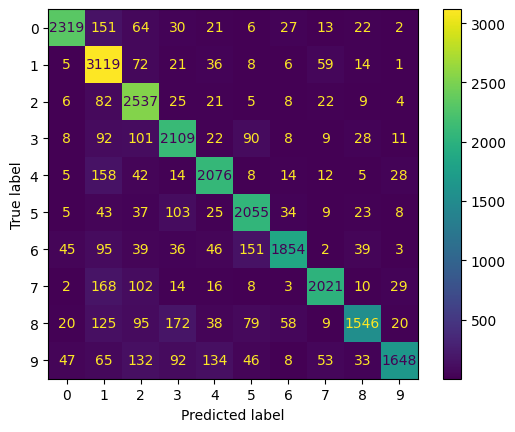

In [11]:
cm_digits = confusion_matrix(digits_test, predicted_number)
ConfusionMatrixDisplay(confusion_matrix=cm_digits, display_labels=digit_classifier.classes_).plot()

In [12]:
recall_score(digits_test, predicted_number, average="micro")

0.85136

------

In [14]:
### it takes about half an hour to give output 

# domain_classifier = RandomForestClassifier(criterion = "entropy", random_state=0)
# grid_search = GridSearchCV(estimator= digit_classifier, param_grid= param_dist)
# grid_search.fit(features_train[:5000], domains_train[:5000])
# print(grid_search.best_params_)
# digit_classifier.fit(features_train, domains_train)

The best parameter acheived from last part was n_estimators = 100 and max depth = 20

In [15]:
domain_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 20, criterion = "entropy", random_state=0)
domain_classifier.fit(features_train, domains_train)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0)

In [16]:
predicted_domain = domain_classifier.predict(features_test)

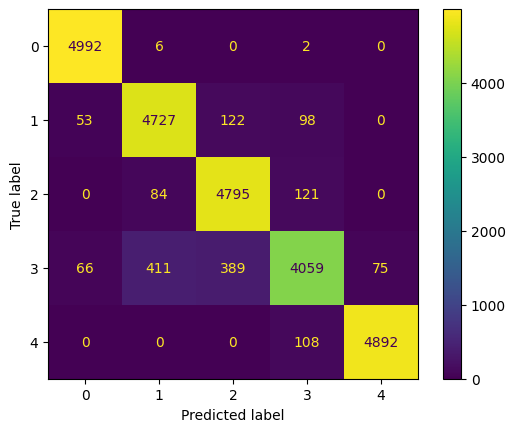

In [17]:
cm_domains = confusion_matrix(domains_test, predicted_domain)
ConfusionMatrixDisplay(confusion_matrix=cm_domains, display_labels=domain_classifier.classes_).plot()

In [18]:
recall_score(domains_test, predicted_domain, average="micro")

0.9386

In [19]:
train_df = pd.DataFrame(features_train)
train_df["domain"] = domains_train
train_df["digit"] = digits_train

In [20]:
models_dict = {}

indices = [0, 1, 2, 3, 4]
# build classification for digits in each domain seperately

for ind in indices:
    temp_train_df = train_df[train_df["domain"]==ind]
  
    model = RandomForestClassifier(n_estimators = 100, max_depth = 20, criterion = "entropy", random_state=0)

    model.fit(temp_train_df.drop(["domain", "digit"], axis = 1), temp_train_df["digit"])

    models_dict[ind] = model

In [21]:
pipe_domain_classifier = domain_classifier
pipe_predicted_domain = pipe_domain_classifier.predict(features_test)

In [23]:
print(models_dict)

{0: RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0), 1: RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0), 2: RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0), 3: RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0), 4: RandomForestClassifier(criterion='entropy', max_depth=20, random_state=0)}


In [24]:
pipe_df = pd.DataFrame(features_test)
pipe_df["domain"] = pipe_predicted_domain
pipe_df["digit"] = 10
pipe_df.columns = pipe_df.columns.astype(str)

# predict digits using specefic model for each domain
for ind in indices:
    temp_pipe_df = pipe_df[pipe_df["domain"]==ind]

    model = models_dict[ind]

    X = temp_pipe_df.drop(["domain", "digit"], axis = 1)

    pipe_df.loc[pipe_df["domain"] == ind, "digit"] = model.predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.86456


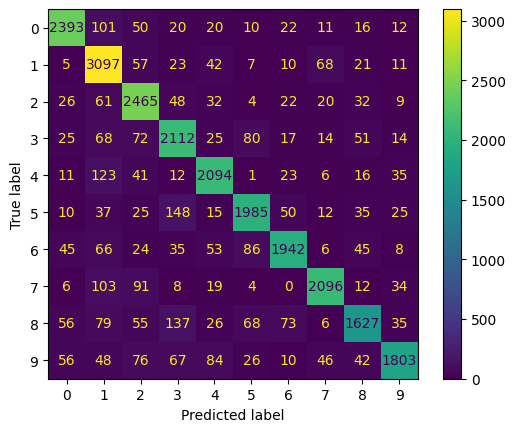

In [25]:
cm_pipe_digits = confusion_matrix(digits_test, pipe_df["digit"])
ConfusionMatrixDisplay(confusion_matrix= cm_pipe_digits, display_labels=model.classes_).plot()

print(recall_score(digits_test, pipe_df["digit"], average="micro"))

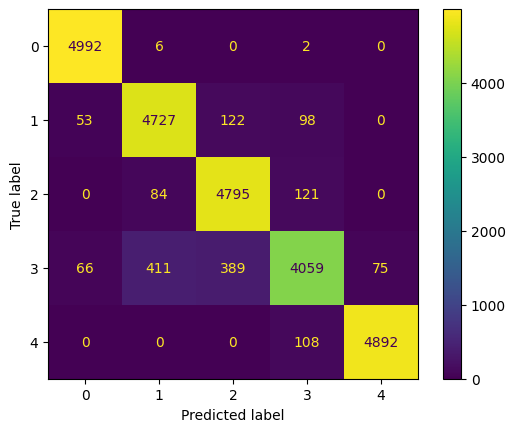

In [26]:
cm_pipe_domains = confusion_matrix(domains_test, pipe_predicted_domain)
ConfusionMatrixDisplay(confusion_matrix= cm_pipe_domains, display_labels=pipe_domain_classifier.classes_).plot()

In [ ]:
# create a new dataframe that append data with similarities in other domains to a domain
new_extended_df = train_df

def extract_data(which_domain, how_many, to_what_domain):
  selected = train_df[train_df["domain"]==which_domain].sample(frac = how_many / 5000)
  selected["domain"] = to_what_domain
  return selected
new_extended_df

In [33]:
# domain 0 resample
# domain 1 to 0
new_extended_df = new_extended_df.append(extract_data(1, 53, 0), ignore_index = True)
# domain 3 to 0
new_extended_df = new_extended_df.append(extract_data(3, 66, 0), ignore_index = True)

# domain 1 resample
# domain 2 to 1
new_extended_df = new_extended_df.append(extract_data(2, 84, 1), ignore_index = True)
# domain 3 to 1
new_extended_df = new_extended_df.append(extract_data(3, 411, 1), ignore_index = True)

# domain 2 resample
# domain 1 to 2
new_extended_df = new_extended_df.append(extract_data(1, 122, 2), ignore_index = True)
# domain 3 to 2
new_extended_df = new_extended_df.append(extract_data(3, 389, 2), ignore_index = True)

# domain 3 resample
# domain 1 to 3
new_extended_df = new_extended_df.append(extract_data(1, 98, 3), ignore_index = True)
# domain 2 to 3
new_extended_df = new_extended_df.append(extract_data(2, 121, 3), ignore_index = True)
# domain 4 to 3
new_extended_df = new_extended_df.append(extract_data(4, 108, 3), ignore_index = True)

# domain 4 resample
# domain 3 to 4
new_extended_df = new_extended_df.append(extract_data(3, 75, 4), ignore_index = True)

<ipython-input-33-95f0a7ff6e9d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_extended_df = new_extended_df.append(extract_data(1, 53, 0), ignore_index = True)
<ipython-input-33-95f0a7ff6e9d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_extended_df = new_extended_df.append(extract_data(3, 66, 0), ignore_index = True)
<ipython-input-33-95f0a7ff6e9d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_extended_df = new_extended_df.append(extract_data(2, 84, 1), ignore_index = True)
<ipython-input-33-95f0a7ff6e9d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_extended_df = new_extended_df.append(extract_data(3, 411,

In [34]:
new_extended_df

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,domain,digit
0,0.962443,0.974911,-0.956540,0.483722,0.843669,0.903815,-0.999779,-0.594352,0.693377,0.369554,...,-0.695665,-0.463567,-0.351819,-0.831733,-0.522023,0.927018,0.996355,-0.962782,3,8
1,0.994080,-0.841685,-0.995020,0.757884,0.424415,0.641307,-0.996342,0.307143,0.611578,0.994697,...,-0.702519,0.560555,0.080402,-0.646949,-0.523018,0.333538,0.145282,-0.326184,3,2
2,0.999433,0.071449,-0.988148,-0.165039,0.992169,-0.971849,-0.997674,-0.932233,0.187991,0.548769,...,-0.716936,0.963427,0.973159,-0.857743,-0.862744,0.371701,0.694743,-0.070631,3,5
3,0.874471,0.988545,-0.763044,0.809770,0.496818,0.955396,-0.397968,0.820809,0.269848,0.898507,...,-0.813466,-0.277753,0.430417,-0.907840,-0.781542,0.649633,-0.362914,-0.970095,3,1
4,0.994623,0.528117,-0.976535,0.804796,0.811454,-0.868849,-0.992567,0.157783,-0.119676,0.996053,...,-0.839148,-0.800681,-0.942170,-0.908701,-0.908787,-0.763906,-0.835947,-0.970095,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28240,0.925182,0.999157,0.987616,-0.422886,0.984158,0.999884,0.707734,0.544123,-0.200718,0.984381,...,-0.787633,-0.563422,-0.008416,0.236494,0.999385,0.998672,0.987538,0.955221,4,1
28241,0.440253,0.942528,-0.884274,0.478904,0.298880,0.830878,-0.450001,0.533174,0.325322,0.740962,...,-0.060259,-0.668315,-0.312326,0.563215,0.360103,0.107510,0.392830,-0.475497,4,3
28242,-0.947716,0.994855,0.875920,-0.402966,-0.998078,0.995399,0.414849,0.906378,-0.886189,-0.102152,...,0.953749,-0.047097,-0.412739,-0.873244,0.981308,0.876580,0.973766,0.998512,4,4
28243,0.781743,0.504661,-0.299088,-0.462474,-0.110367,-0.550988,-0.442047,-0.501743,0.243290,-0.459455,...,0.473895,-0.684635,-0.871296,-0.760939,-0.405317,-0.518843,-0.312600,-0.711169,4,8


In [35]:
new_models_dict = {}

# model on each domain separately with the new dataframe
for ind in indices:
    temp_train_df = new_extended_df[new_extended_df["domain"]==ind]
  
    model = RandomForestClassifier(n_estimators = 100, max_depth = 10, criterion = "entropy", random_state=0)

    model.fit(temp_train_df.drop(["domain", "digit"], axis = 1), temp_train_df["digit"])

    new_models_dict[ind] = model

In [36]:
pipe_df = pd.DataFrame(features_test)
pipe_df["domain"] = pipe_predicted_domain
pipe_df["digit"] = 10
pipe_df.columns = pipe_df.columns.astype(str)
for ind in indices:
    temp_pipe_df = pipe_df[pipe_df["domain"]==ind]

    model = new_models_dict[ind]

    X = temp_pipe_df.drop(["domain", "digit"], axis = 1)

    pipe_df.loc[pipe_df["domain"] == ind, "digit"] = model.predict(X)
    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.8676


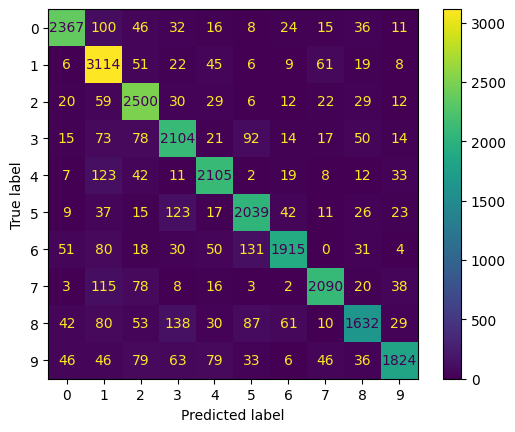

In [37]:
cm_pipe_digits = confusion_matrix(digits_test, pipe_df["digit"])
ConfusionMatrixDisplay(confusion_matrix= cm_pipe_digits, display_labels=model.classes_).plot()

print(recall_score(digits_test, pipe_df["digit"], average="micro"))

Authors: Pouria Nazemi - Tahoora Saeedi